# RCS of a dielectric sphere via a near-to-far field transformation

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/a86bc42d97aceaf6ad31b83f14408bd808e38795?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FNear2FarSphereRCS.ipynb).

This tutorial will show you how to compute the radar cross section (RCS) for a dielectric sphere by sampling scattered near fields on a closed surface surrounding the sphere, and transforming them to observation points far away.

This example demonstrates the usefulness of the near field to far field transformation for reducing the simulation size needed for structures involving lots of empty space.

To obtain the scattered field, we will run two simulations:
* one with the sphere to compute the total near field on a closed surface around the sphere, and
* one without the sphere, to compute just the incident field and subtract it from the above to get the scattered field.

Then, we'll show how to use the `Near2Far` feature from `Tidy3D` to extrapolate to the fields at the focal plane above the lens.

In [1]:
%load_ext autoreload
%autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

Using Tidy3D credentials from stored file


## Define Simulation Parameters

We first need to define our simulation parameters and the structure.  As a reminder, all length units in `tidy3D` are specified in microns.

In [2]:
# for easy conversion of units
unit = 1

# radius and location of the sphere
radius = 0.5 * unit
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# free space central wavelength
wavelength = (2.0 * radius) / 2.0
f0 = td.C_0 / wavelength

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 3 * wavelength

# distance between the sphere and the near field monitor along each cartesian direction
buffer_mon = 1 * wavelength

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
grids_per_wavelength = 40

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=diel)
geometry = [sphere]

# grid size (um)
dl = wavelength / grids_per_wavelength

# define PML layers
pml_layers = 3*[td.PML()]

# set the domain size in x, y, and z
domain_size = buffer_PML + 2 * radius + buffer_PML

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

## Create Source

Create a plane wave incident from below the sphere polarized in the x direction

In [3]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source below the sphere, propagating in the +z direction
source = td.PlaneWave(
    center=(0,0,-(radius + 3 * buffer_PML / 4)),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 50 / fwidth


## Create Monitor

Create a near field monitor enclosing the sphere to measure the total near fields.
A box monitor will be created, and then its 6 surfaces will be extracted, since we are only interested in transforming fields tangential to the monitor's surface.

In [4]:
# create a volume monitor around the sphere
mon_size = 2 * radius + 2 * buffer_mon
#mon_size = wavelength
monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='near_field')

# get the surface monitors associated with the volume monitor
monitors = monitor.surfaces()

## Create Simulation

Now we can put everything together and define the two simulation classes: with the sphere to get the total field, and without the sphere to get the incident field.

In [5]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

sim_empty = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

## Visualize Geometry

Let's take a look and make sure everything is defined properly in both simulations


<Figure size 648x216 with 4 Axes>

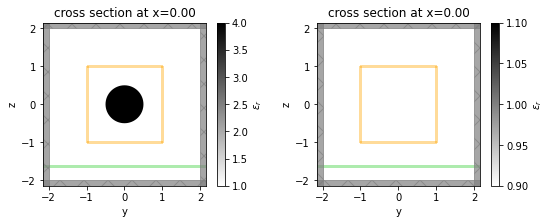

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim.plot_eps(x=0, ax=ax1);
sim_empty.plot_eps(x=0, ax=ax2);

## Run Simulations

Now we can run both simulations over time and measure the results


In [7]:
# Run simulation
import tidy3d.web as web

# sim_data = web.run(sim, task_name='sphereRCS', path='data/sphereRCS.hdf5')
# sim_empty_data = web.run(sim_empty, task_name='sphereRCS_empty', path='data/sphereRCS_empty.hdf5')

sim_data = td.SimulationData.from_file(fname='data/sphereRCS.hdf5')
sim_data = sim_data.normalize()

sim_empty_data = td.SimulationData.from_file(fname='data/sphereRCS_empty.hdf5')
sim_empty_data = sim_empty_data.normalize()

# compute scattered fields by subtracting out the incident fields from the empty simulation
for mon in monitors:
    sim_data[mon.name].Ex -= sim_empty_data[mon.name].Ex
    sim_data[mon.name].Ey -= sim_empty_data[mon.name].Ey
    sim_data[mon.name].Ez -= sim_empty_data[mon.name].Ez

    sim_data[mon.name].Hx -= sim_empty_data[mon.name].Hx
    sim_data[mon.name].Hy -= sim_empty_data[mon.name].Hy
    sim_data[mon.name].Hz -= sim_empty_data[mon.name].Hz

We now can inspect the near field patterns on the near field monitors using the Tidy3D built in field visualization methods.

<Figure size 864x216 with 6 Axes>

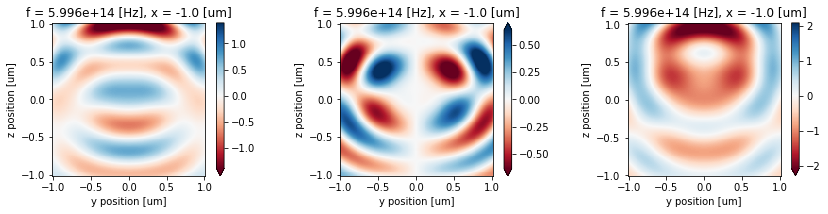

<Figure size 864x216 with 6 Axes>

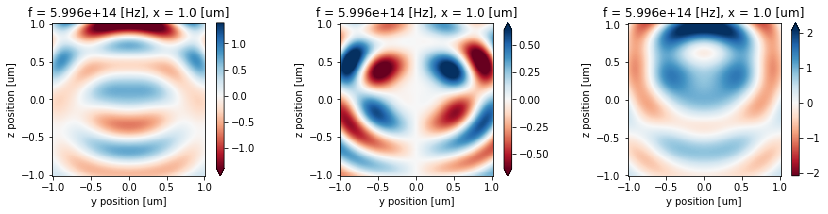

<Figure size 864x216 with 6 Axes>

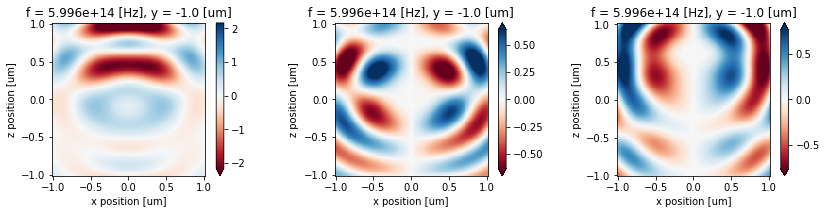

<Figure size 864x216 with 6 Axes>

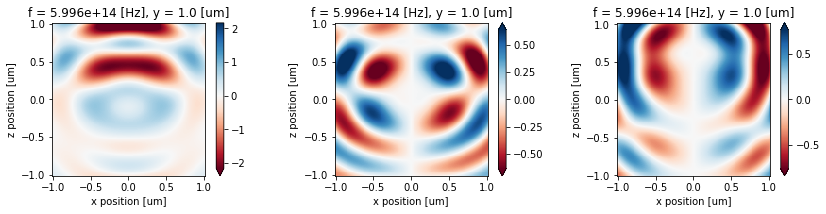

<Figure size 864x216 with 6 Axes>

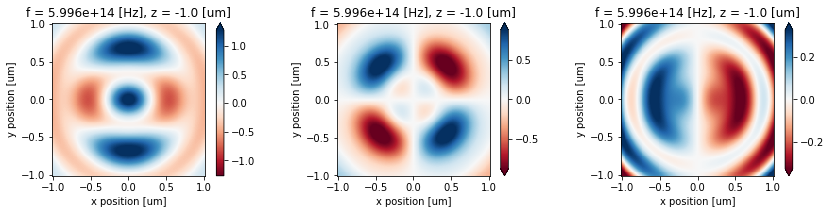

<Figure size 864x216 with 6 Axes>

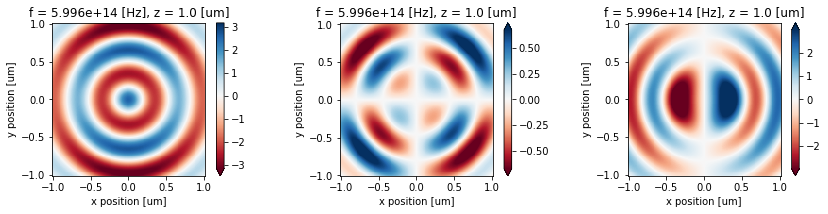

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ex', x=monitors[0].center[0], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ey', x=monitors[0].center[0], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ez', x=monitors[0].center[0], val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ex', x=monitors[1].center[0], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ey', x=monitors[1].center[0], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ez', x=monitors[1].center[0], val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ex', y=monitors[2].center[1], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ey', y=monitors[2].center[1], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ez', y=monitors[2].center[1], val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ex', y=monitors[3].center[1], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ey', y=monitors[3].center[1], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ez', y=monitors[3].center[1], val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ex', z=monitors[4].center[2], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ey', z=monitors[4].center[2], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ez', z=monitors[4].center[2], val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ex', z=monitors[5].center[2], val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ey', z=monitors[5].center[2], val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ez', z=monitors[5].center[2], val='real', freq=f0, ax=ax3)

plt.show()


## Setting Up Near2Far

To set up the near-to-far transformation, we need to grab the fields on each surface of the near-field box monitor, which was already accomplished with the 'surfaces()' function.
So, we simply create a `td.Near2Far` object and pass in the surface monitors as shown below.
This object just stores near field data and provides [various methods](https://simulation.cloud/docs/html/generated/tidy3d.Near2Far.html#tidy3d.Near2Far) for looking at various far field quantities.
We can optionally pass in the number of points per wavelength with which to sample fields on the monitors. The default is 10, and in many cases one can get away with as few as 5 points per wavelength.

In [9]:
from tidy3d.plugins import Near2Far, Near2FarSurface

n2f = Near2Far.from_surface_monitors(
    sim_data=sim_data, 
    mons=monitors, 
    normal_dirs=['-','+','-','+','-','+'], 
    frequency=f0, 
    pts_per_wavelength=10
)

In [10]:
# projection distance
far_distance = 100 * wavelength

num_theta = 300
num_phi = 2
thetas = np.linspace(0, np.pi, num_theta)
phis = np.linspace(0, np.pi/2, num_phi)

# initialize the far field values
RCS = np.zeros((num_theta, num_phi), dtype=float)
E = np.zeros((3, num_theta, num_phi), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(np.arange(len(thetas)), description='Performing far-field transformation...'):

    theta = thetas[i]
    for j in np.arange(len(phis)):
        phi = phis[j]

        # compute and store the outputs from projection function at the focal plane
        _RCS = n2f.radar_cross_section(theta, phi)
        RCS[i, j] = np.squeeze(_RCS)

        _E, _H = n2f.fields_spherical(far_distance, theta, phi)
        E[:, i, j] = np.squeeze(_E)

Output()

/tmp/ipykernel_1300365/2336000753.py:9: RuntimeWarning: invalid value encountered in true_divide
  val = val / np.max(np.abs(val))
/tmp/ipykernel_1300365/2336000753.py:9: RuntimeWarning: invalid value encountered in true_divide
  val = val / np.max(np.abs(val))


<Figure size 540x360 with 1 Axes>

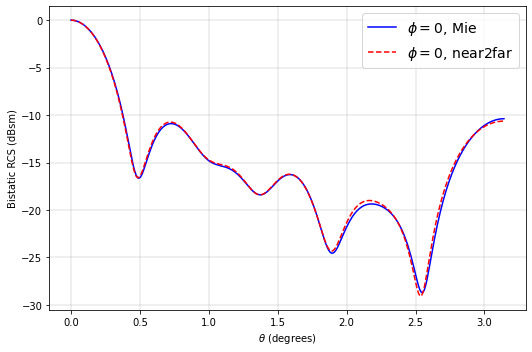

<Figure size 540x360 with 1 Axes>

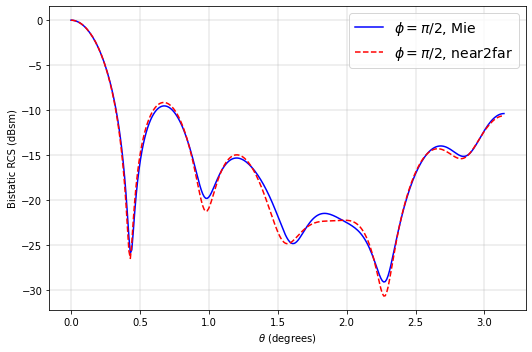

<Figure size 540x360 with 1 Axes>

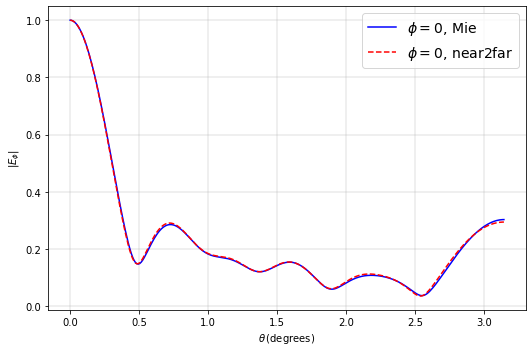

<Figure size 540x360 with 1 Axes>

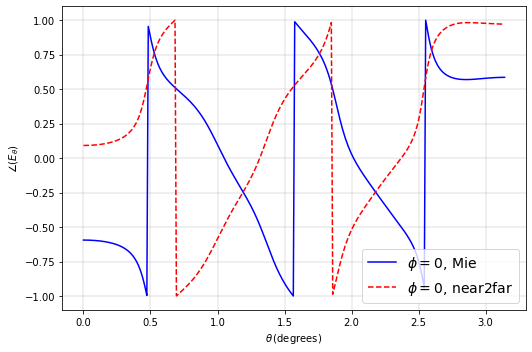

<Figure size 540x360 with 1 Axes>

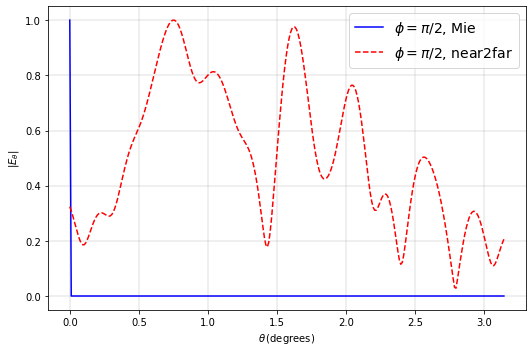

<Figure size 540x360 with 1 Axes>

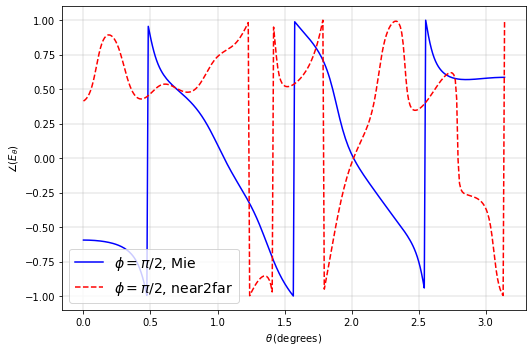

<Figure size 540x360 with 1 Axes>

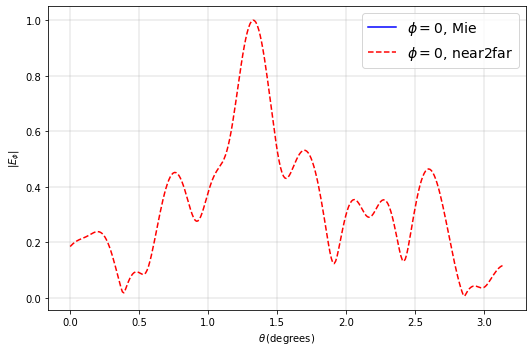

<Figure size 540x360 with 1 Axes>

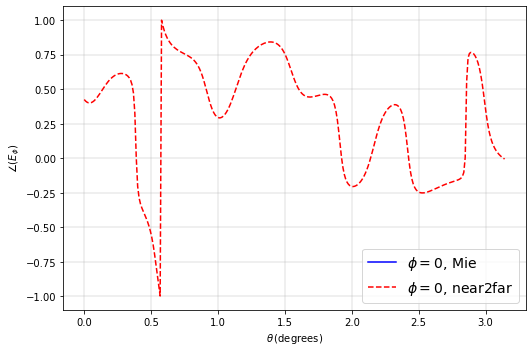

<Figure size 540x360 with 1 Axes>

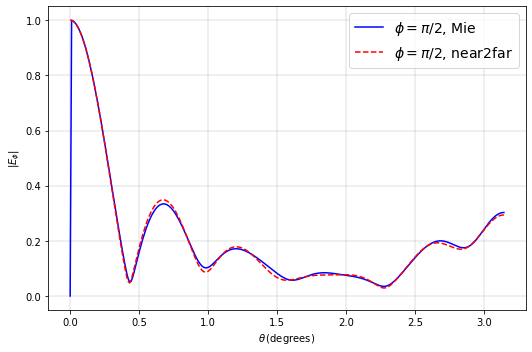

<Figure size 540x360 with 1 Axes>

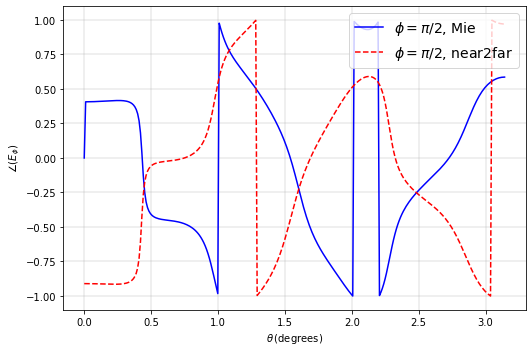

In [11]:
def scale_fn(val):
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

def plot_fn(val):
    return np.abs(val)

def plot_fn2(val):
    val = val / np.max(np.abs(val))
    return val

fileid = '2lambda_epsr4'


# ====== RCS ======

RCS_phi0 = scale_fn(np.squeeze(RCS[:,0]))
RCS_phi90 = scale_fn(np.squeeze(RCS[:,1]))

mie_filename_phi0 = "./data/mie_bRCS_phi0_" + fileid + ".txt"
mie_filename_phi90 = "./data/mie_bRCS_phi90_" + fileid + ".txt"

mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
mie_phi0 = scale_fn(np.squeeze(mie_data_phi0[:,[1]]))

mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
mie_phi90 = scale_fn(np.squeeze(mie_data_phi90[:,[1]]))

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi0, mie_phi0, '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, RCS_phi0, '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi90, mie_phi90, '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, RCS_phi90, '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()


# ====== E ======

Eth_phi0 = ((np.squeeze(E[1,:,0])))
Eth_phi90 = ((np.squeeze(E[1,:,1])))

Eph_phi0 = ((np.squeeze(E[2,:,0])))
Eph_phi90 = ((np.squeeze(E[2,:,1])))

mie_E_filename_phi0 = "./data/mie_E_phi0_" + fileid + ".txt"
mie_E_filename_phi90 = "./data/mie_E_phi90_" + fileid + ".txt"

mie_E_data_phi0 = np.loadtxt(mie_E_filename_phi0, delimiter=' ', skiprows=2)
mie_E_theta_phi0 = np.squeeze(mie_E_data_phi0[:,[0]])
mie_Eth_phi0 = (np.squeeze(mie_E_data_phi0[:,[3]] + 1j*mie_E_data_phi0[:,[4]]))
mie_Eph_phi0 = (np.squeeze(mie_E_data_phi0[:,[5]] + 1j*mie_E_data_phi0[:,[6]]))

mie_E_data_phi90 = np.loadtxt(mie_E_filename_phi90, delimiter=' ', skiprows=2)
mie_E_theta_phi90 = np.squeeze(mie_E_data_phi90[:,[0]])
mie_Eth_phi90 = (np.squeeze(mie_E_data_phi90[:,[3]] + 1j*mie_E_data_phi90[:,[4]]))
mie_Eph_phi90 = (np.squeeze(mie_E_data_phi90[:,[5]] + 1j*mie_E_data_phi90[:,[6]]))

# ------ E_theta, phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eth_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eth_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, -plot_fn2(np.angle(mie_Eth_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eth_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\theta)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_theta, phi = 90 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eth_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eth_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\theta|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, -plot_fn2(np.angle(mie_Eth_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eth_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\theta)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_phi, phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eph_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eph_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, -plot_fn2(np.angle(mie_Eph_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eph_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\phi)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_phi, phi = 90 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eph_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eph_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, -plot_fn2(np.angle(mie_Eph_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eph_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\phi)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

plt.show()

In [12]:
# # Export the set of coordinates at which E and H live on the Yee grid
# path = '/home/shashwat/flexcompute/repositories/tidy3d-mytests/temp/'

# for mon in monitors:
    
#     mon_axis = np.argmin(mon.size)
#     field_data = sim_data[mon.name]
    
#     if mon_axis == 0:
#         required_fields = ("y", "z")
#     elif mon_axis == 1:
#         required_fields = ("x", "z")
#     else:
#         required_fields = ("x", "y")
    
#     Eu = field_data["E"+required_fields[0]].sel(f=f0)
#     Ev = field_data["E"+required_fields[1]].sel(f=f0)

#     Hu = field_data["H"+required_fields[0]].sel(f=f0)
#     Hv = field_data["H"+required_fields[1]].sel(f=f0)
    
    
#     name = path + mon.name + '_x_Hu.txt'
#     np.savetxt(name, Hu.x.values, fmt='%f')
    
#     name = path + mon.name + '_y_Hu.txt'
#     np.savetxt(name, Hu.y.values, fmt='%f')

#     name = path + mon.name + '_z_Hu.txt'
#     np.savetxt(name, Hu.z.values, fmt='%f')

    
#     name = path + mon.name + '_x_Hv.txt'
#     np.savetxt(name, Hv.x.values, fmt='%f')
    
#     name = path + mon.name + '_y_Hv.txt'
#     np.savetxt(name, Hv.y.values, fmt='%f')

#     name = path + mon.name + '_z_Hv.txt'
#     np.savetxt(name, Hv.z.values, fmt='%f')

    
#     name = path + mon.name + '_x_Eu.txt'
#     np.savetxt(name, Eu.x.values, fmt='%f')
    
#     name = path + mon.name + '_y_Eu.txt'
#     np.savetxt(name, Eu.y.values, fmt='%f')

#     name = path + mon.name + '_z_Eu.txt'
#     np.savetxt(name, Eu.z.values, fmt='%f')

    
#     name = path + mon.name + '_x_Ev.txt'
#     np.savetxt(name, Ev.x.values, fmt='%f')
    
#     name = path + mon.name + '_y_Ev.txt'
#     np.savetxt(name, Ev.y.values, fmt='%f')

#     name = path + mon.name + '_z_Ev.txt'
#     np.savetxt(name, Ev.z.values, fmt='%f')
  
#     # b = np.loadtxt(name, dtype=float)
#     # print(b)


In [13]:

# #sim_data = copy.deepcopy(sim_data_save)

# for mon, i in zip(monitors, np.arange(len(monitors))):
    
#     mon_axis = np.argmin(mon.size)
#     field_data = sim_data[mon.name]
    
#     #print(sim_data[mon.name])
        
#     if mon_axis == 0:
#         required_fields = ("y", "z")
#     elif mon_axis == 1:
#         required_fields = ("x", "z")
#     else:
#         required_fields = ("x", "y")
    
#     fname = path + 'Hu_' + str(i) + '.txt'
#     new_data = np.loadtxt(fname, dtype=complex)
#     with open(fname) as f:
#         first_line = f.readline()
#         first_line = first_line.split("(",1)[1][:-2]
#         sizes = list(map(int, first_line.split(',')))
#     new_data = new_data.reshape(sizes)
#     sim_data[mon.name].data_dict["H"+required_fields[0]].values = new_data[..., None]

#     fname = path + 'Hv_' + str(i) + '.txt'
#     new_data = np.loadtxt(fname, dtype=complex)
#     with open(fname) as f:
#         first_line = f.readline()
#         first_line = first_line.split("(",1)[1][:-2]
#         sizes = list(map(int, first_line.split(',')))
#     new_data = new_data.reshape(sizes)
#     sim_data[mon.name].data_dict["H"+required_fields[1]].values = new_data[..., None]

#     fname = path + 'Eu_' + str(i) + '.txt'
#     new_data = np.loadtxt(fname, dtype=complex)
#     with open(fname) as f:
#         first_line = f.readline()
#         first_line = first_line.split("(",1)[1][:-2]
#         sizes = list(map(int, first_line.split(',')))
#     new_data = new_data.reshape(sizes)
#     sim_data[mon.name].data_dict["E"+required_fields[0]].values = new_data[..., None]

#     fname = path + 'Ev_' + str(i) + '.txt'
#     new_data = np.loadtxt(fname, dtype=complex)
#     with open(fname) as f:
#         first_line = f.readline()
#         first_line = first_line.split("(",1)[1][:-2]
#         sizes = list(map(int, first_line.split(',')))
#     new_data = new_data.reshape(sizes)
#     sim_data[mon.name].data_dict["E"+required_fields[1]].values = new_data[..., None]

#     #Eu = field_data["E"+required_fields[0]].sel(f=f0)
#     #Ev = field_data["E"+required_fields[1]].sel(f=f0)

#     #Hu = field_data["H"+required_fields[0]].sel(f=f0)
#     #Hv = field_data["H"+required_fields[1]].sel(f=f0)





In [14]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ex', x=monitors[0].center[0], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ey', x=monitors[0].center[0], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ez', x=monitors[0].center[0], val='real', freq=f0, ax=ax3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ex', x=monitors[1].center[0], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ey', x=monitors[1].center[0], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ez', x=monitors[1].center[0], val='real', freq=f0, ax=ax3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ex', y=monitors[2].center[1], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ey', y=monitors[2].center[1], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ez', y=monitors[2].center[1], val='real', freq=f0, ax=ax3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ex', y=monitors[3].center[1], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ey', y=monitors[3].center[1], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ez', y=monitors[3].center[1], val='real', freq=f0, ax=ax3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ex', z=monitors[4].center[2], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ey', z=monitors[4].center[2], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ez', z=monitors[4].center[2], val='real', freq=f0, ax=ax3)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

# sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ex', z=monitors[5].center[2], val='real', freq=f0, ax=ax1)
# sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ey', z=monitors[5].center[2], val='real', freq=f0, ax=ax2)
# sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ez', z=monitors[5].center[2], val='real', freq=f0, ax=ax3)

# plt.show()

In [15]:
# n2fmons = copy.deepcopy(monitors)
# #del n2fmons[0:3]
# n2f = Near2Far(sim_data, mons=n2fmons, frequency=f0, pts_per_wavelength=5)
# n2f.spacetime_sign = -1

# # projection distance
# far_distance = 100 * wavelength

# num_theta = 300
# num_phi = 2
# thetas = np.linspace(0, np.pi, num_theta)
# phis = np.linspace(0, np.pi/2, num_phi)

# # initialize the far field values
# RCS = np.zeros((num_theta, num_phi), dtype=float)
# E = np.zeros((3, num_theta, num_phi), dtype=complex)

# from rich.progress import track

# # loop through points in the output plane
# for i in track(np.arange(len(thetas)), description='Performing far-field transformation...'):

#     theta = thetas[i]
#     for j in np.arange(len(phis)):
#         phi = phis[j]

#         # compute and store the outputs from projection function at the focal plane
#         _RCS = n2f.radar_cross_section(far_distance, theta, phi)
#         RCS[i, j] = np.squeeze(_RCS)

#         _E, _H = n2f.fields_spherical(far_distance, theta, phi)
#         E[:, i, j] = np.squeeze(_E)
        
#         #print(RCS[i, j], E[i, j])



In [16]:
# def scale_fn(val):
#     val = val / np.max(np.abs(val))
#     return 10.0*np.log10(val)

# def plot_fn(val):
#     return np.abs(val)

# def plot_fn2(val):
#     val = val / np.max(np.abs(val))
#     return val

# fileid = '0p2lamb_epsr4'


# # ====== RCS ======

# RCS_phi0 = scale_fn(np.squeeze(RCS[:,0]))
# RCS_phi90 = scale_fn(np.squeeze(RCS[:,1]))

# mie_filename_phi0 = "./data/mie_bRCS_phi0_" + fileid + ".txt"
# mie_filename_phi90 = "./data/mie_bRCS_phi90_" + fileid + ".txt"

# mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
# mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
# mie_phi0 = scale_fn(np.squeeze(mie_data_phi0[:,[1]]))

# mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
# mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
# mie_phi90 = scale_fn(np.squeeze(mie_data_phi90[:,[1]]))

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_theta_phi0, mie_phi0, '-b', label="$\\phi = 0$, Mie")
# ax.plot(thetas, RCS_phi0, '.--b', label="$\\phi = 0$, near2far")
# ax.set(xlabel = "$\\theta$ (degrees)",
#        ylabel = "Bistatic RCS (dBsm)",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_theta_phi90, mie_phi90, '-r', label="$\\phi = \\pi/2$, Mie")
# ax.plot(thetas, RCS_phi90, '.--r', label="$\\phi = \\pi/2$, near2far")
# ax.set(xlabel = "$\\theta$ (degrees)",
#        ylabel = "Bistatic RCS (dBsm)",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()


# # ====== E ======

# Eth_phi0 = ((np.squeeze(E[1,:,0])))
# Eth_phi90 = ((np.squeeze(E[1,:,1])))

# Eph_phi0 = ((np.squeeze(E[2,:,0])))
# Eph_phi90 = ((np.squeeze(E[2,:,1])))

# mie_E_filename_phi0 = "./data/mie_E_phi0_" + fileid + ".txt"
# mie_E_filename_phi90 = "./data/mie_E_phi90_" + fileid + ".txt"

# mie_E_data_phi0 = np.loadtxt(mie_E_filename_phi0, delimiter=' ', skiprows=2)
# mie_E_theta_phi0 = np.squeeze(mie_E_data_phi0[:,[0]])
# mie_Eth_phi0 = (np.squeeze(mie_E_data_phi0[:,[3]] + 1j*mie_E_data_phi0[:,[4]]))
# mie_Eph_phi0 = (np.squeeze(mie_E_data_phi0[:,[5]] + 1j*mie_E_data_phi0[:,[6]]))

# mie_E_data_phi90 = np.loadtxt(mie_E_filename_phi90, delimiter=' ', skiprows=2)
# mie_E_theta_phi90 = np.squeeze(mie_E_data_phi90[:,[0]])
# mie_Eth_phi90 = (np.squeeze(mie_E_data_phi90[:,[3]] + 1j*mie_E_data_phi90[:,[4]]))
# mie_Eph_phi90 = (np.squeeze(mie_E_data_phi90[:,[5]] + 1j*mie_E_data_phi90[:,[6]]))

# # ------ E_theta, phi = 0 ------

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eth_phi0)), '-b', label="$\\phi = 0$, Mie")
# ax.plot(thetas, plot_fn2(np.abs(Eth_phi0)), '--.b', label="$\\phi = 0$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$|E_\\phi|$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi0, plot_fn2(np.angle(mie_Eth_phi0)), '-r', label="$\\phi = 0$, Mie")
# ax.plot(thetas, plot_fn2(np.angle(Eth_phi0)), '--.r', label="$\\phi = 0$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$\\angle(E_\\theta)$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# # ------ E_theta, phi = 90 ------

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eth_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
# ax.plot(thetas, plot_fn2(np.abs(Eth_phi90)), '--.b', label="$\\phi = \\pi/2$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$|E_\\theta|$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi90, plot_fn2(np.angle(mie_Eth_phi90)), '-r', label="$\\phi = \\pi/2$, Mie")
# ax.plot(thetas, plot_fn2(np.angle(Eth_phi90)), '--.r', label="$\\phi = \\pi/2$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$\\angle(E_\\theta)$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# # ------ E_phi, phi = 0 ------

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eph_phi0)), '-b', label="$\\phi = 0$, Mie")
# ax.plot(thetas, plot_fn2(np.abs(Eph_phi0)), '--.b', label="$\\phi = 0$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$|E_\\phi|$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi0, plot_fn2(np.angle(mie_Eph_phi0)), '-r', label="$\\phi = 0$, Mie")
# ax.plot(thetas, plot_fn2(np.angle(Eph_phi0)), '--.r', label="$\\phi = 0$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$\\angle(E_\\phi)$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# # ------ E_phi, phi = 90 ------

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eph_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
# ax.plot(thetas, plot_fn2(np.abs(Eph_phi90)), '--.b', label="$\\phi = \\pi/2$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$|E_\\phi|$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(7.5, 5))

# ax.plot(mie_E_theta_phi90, plot_fn2(np.angle(mie_Eph_phi90)), '-r', label="$\\phi = \\pi/2$, Mie")
# ax.plot(thetas, plot_fn2(np.angle(Eph_phi90)), '--.r', label="$\\phi = \\pi/2$, near2far")
# ax.set(xlabel = "$\\theta\\,$(degrees)",
#        ylabel = "$\\angle(E_\\phi)$",
#        yscale = 'linear',
#        xscale = 'linear'
#       )
# ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
# plt.legend(loc='best', prop={'size': 14})
# plt.tight_layout()

# plt.show()

<Figure size 864x216 with 6 Axes>

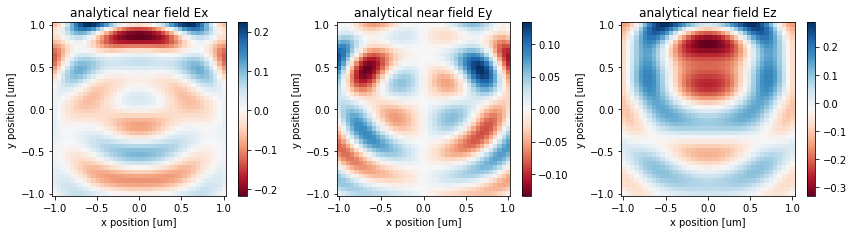

<Figure size 864x216 with 6 Axes>

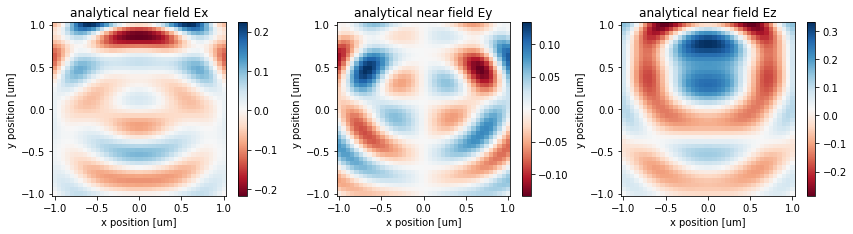

<Figure size 864x216 with 6 Axes>

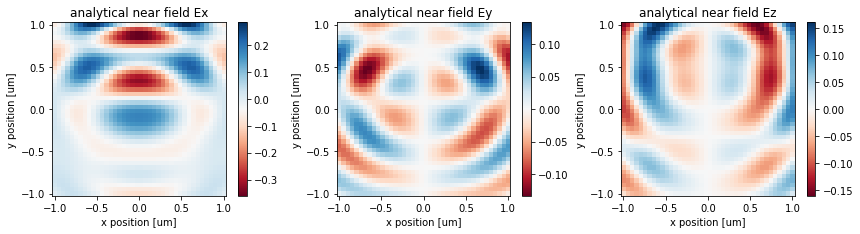

<Figure size 864x216 with 6 Axes>

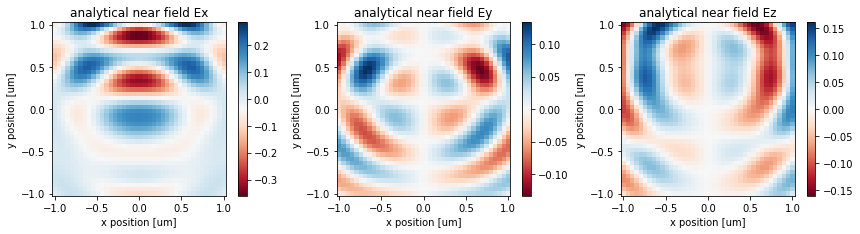

<Figure size 864x216 with 6 Axes>

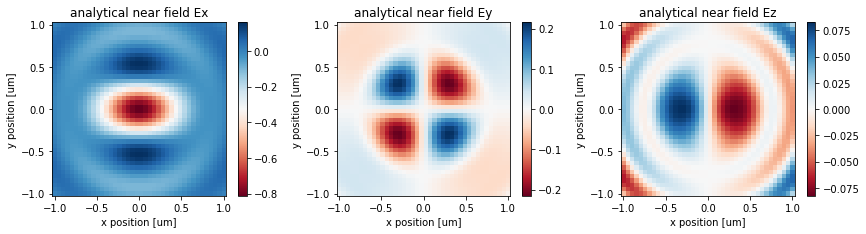

<Figure size 864x216 with 6 Axes>

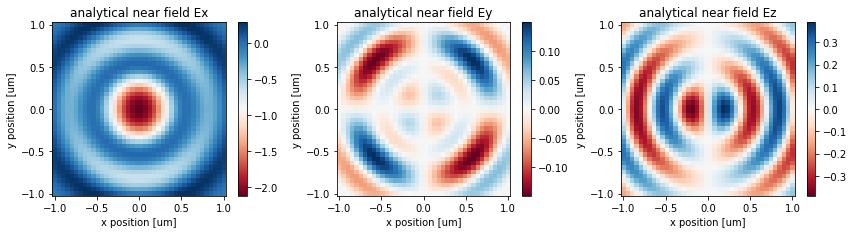

In [17]:
from tidy3d.plugins import Near2Far
# import multiprocessing
# from joblib import Parallel, delayed
from multiprocessing import Pool

n2fa = Near2Far.from_surface_monitors(
    sim_data=sim_data, 
    mons=monitors, 
    normal_dirs=['-','+','-','+','-','+'], 
    frequency=f0, 
    pts_per_wavelength=10,
)
n2fa.initialize()
n2fa.phasor_sign = -1

import sys
sys.path.insert(1, '/home/shashwat/flexcompute/repositories/Python-Sphere-RCS')
from getRCS import *

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

def plot_E_components(plot_x, plot_y, E_near):
    
    fig, (axes) =  plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()

    for ax, direction, E in zip(axes, 'xyz', E_near):
        im = pmesh(plot_x, plot_y, plotfunc(E), ax=ax, cmap='RdBu')
        ax.set_title(f'analytical near field E{direction}')
        ax.set_aspect(1)
        ax.set_xlabel('x position [um]')
        ax.set_ylabel('y position [um]')
        plt.colorbar(im, ax=ax)
        
background_material = DielectricMaterial(1,0)
sphere_material = DielectricMaterial(diel.permittivity, 0, 1, 0, name="test")

def compute_Mie_fields(us, vs, w, axis):
    
    E_car = np.zeros((3, len(us), len(vs)), dtype=complex)
    H_car = np.zeros((3, len(us), len(vs)), dtype=complex)

    i = -1
    for u in us:
        i += 1
        j = -1
        for v in vs:
            j += 1

            if axis == 0:
                r, theta, phi = n2fa._car_2_sph(w, u, v)
            elif axis == 1:
                r, theta, phi = n2fa._car_2_sph(u, w, v)
            else:
                r, theta, phi = n2fa._car_2_sph(u, v, w)

            _, _E_car, _, _H_car = ComputeEH(
                radius, 
                [f0/1e6], 
                background_material, 
                sphere_material, 
                r, 
                theta, 
                phi)

            E_car[:, i, j] = [item for sublist in _E_car for item in sublist]
            H_car[:, i, j] = [item for sublist in _H_car for item in sublist]

    return E_car, H_car

def set_Mie_field(surface):
    
    xp = surface.currents['x'].values
    yp = surface.currents['y'].values
    zp = surface.currents['z'].values

    if surface.axis == 0:
        
        E_near_an, H_near_an = compute_Mie_fields(yp, zp, xp, surface.axis)
        
        plot_E_components(yp, zp, E_near_an)
        
        signs = [-1.0, 1.0]
        if surface.normal_dir == '-':
            signs = [-1.0 * i for i in signs]

        surface.currents['Jy'].values = signs[0] * H_near_an[2]
        surface.currents['Jz'].values = signs[1] * H_near_an[1]
        
        surface.currents['My'].values = signs[1] * E_near_an[2]
        surface.currents['Mz'].values = signs[0] * E_near_an[1]
        
    elif surface.axis == 1:
        
        E_near_an, H_near_an = compute_Mie_fields(xp, zp, yp, surface.axis)

        plot_E_components(xp, zp, E_near_an)

        signs = [1.0, -1.0]
        if surface.normal_dir == '-':
            signs = [-1.0 * i for i in signs]

        surface.currents['Jx'].values = signs[0] * H_near_an[2]
        surface.currents['Jz'].values = signs[1] * H_near_an[0]
        
        surface.currents['Mx'].values = signs[1] * E_near_an[2]
        surface.currents['Mz'].values = signs[0] * E_near_an[0]

    else:
        
        E_near_an, H_near_an = compute_Mie_fields(xp, yp, zp, surface.axis)

        plot_E_components(xp, yp, E_near_an)

        signs = [-1.0, 1.0]
        if surface.normal_dir == '-':
            signs = [-1.0 * i for i in signs]

        surface.currents['Jx'].values = signs[0] * H_near_an[1]
        surface.currents['Jy'].values = signs[1] * H_near_an[0]
        
        surface.currents['Mx'].values = signs[1] * E_near_an[1]
        surface.currents['My'].values = signs[0] * E_near_an[0]
        
    return surface
        
n_jobs = len(n2fa.surfaces)

# surfaces = Parallel(n_jobs=n_jobs)(
#     delayed(set_Mie_field)(surface) for surface in n2fa.surfaces)

# for n2f_surface, surface in zip(n2fa.surfaces, surfaces):
#     n2f_surface = surface
    
# p = Pool(processes=n_jobs)
# n2fa.surfaces = p.map(set_Mie_field, n2fa.surfaces)
# p.close()
# p.join()
    

for surface in n2fa.surfaces:
    surface = set_Mie_field(surface)

plt.show()


In [18]:
# projection distance
far_distance = 100 * wavelength

num_theta = 300
num_phi = 2
thetas = np.linspace(0, np.pi, num_theta)
phis = np.linspace(0, np.pi/2, num_phi)

# initialize the far field values
RCS = np.zeros((num_theta, num_phi), dtype=float)
E = np.zeros((3, num_theta, num_phi), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(np.arange(len(thetas)), description='Performing far-field transformation...'):

    theta = thetas[i]
    for j in np.arange(len(phis)):
        phi = phis[j]

        # compute and store the outputs from projection function at the focal plane
        _RCS = n2fa.radar_cross_section(theta, phi)
        RCS[i, j] = np.squeeze(_RCS)

        _E, _H = n2fa.fields_spherical(far_distance, theta, phi)
        E[:, i, j] = np.squeeze(_E)

Output()

/tmp/ipykernel_1300365/2336000753.py:9: RuntimeWarning: invalid value encountered in true_divide
  val = val / np.max(np.abs(val))
/tmp/ipykernel_1300365/2336000753.py:9: RuntimeWarning: invalid value encountered in true_divide
  val = val / np.max(np.abs(val))


<Figure size 540x360 with 1 Axes>

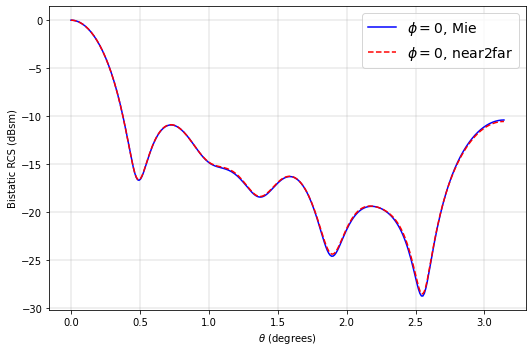

<Figure size 540x360 with 1 Axes>

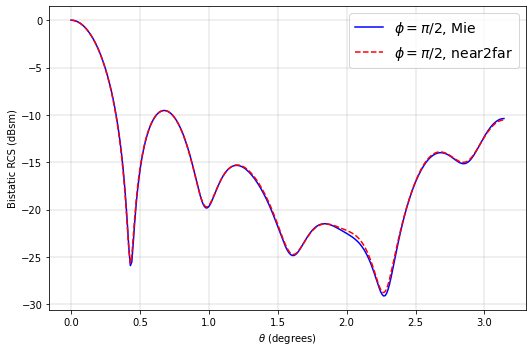

<Figure size 540x360 with 1 Axes>

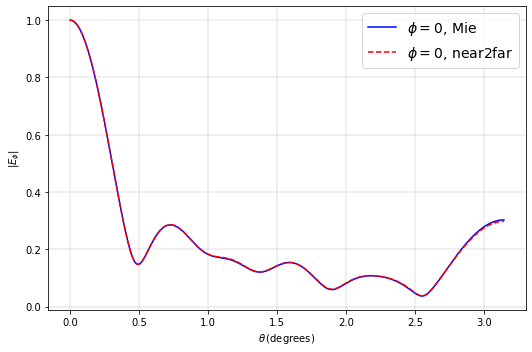

<Figure size 540x360 with 1 Axes>

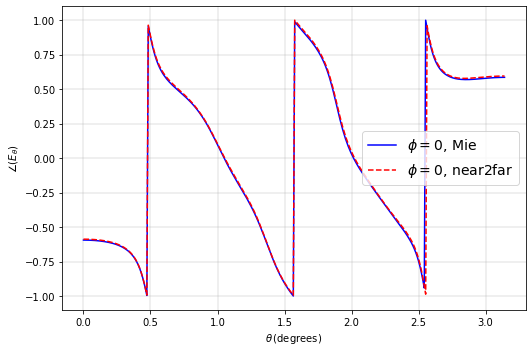

<Figure size 540x360 with 1 Axes>

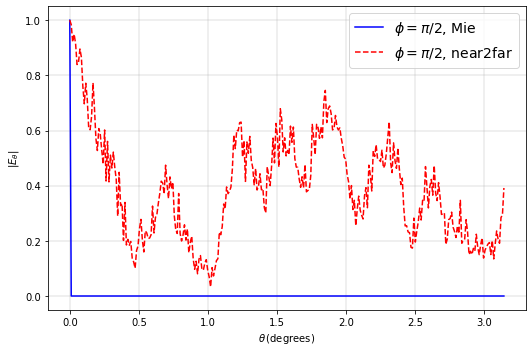

<Figure size 540x360 with 1 Axes>

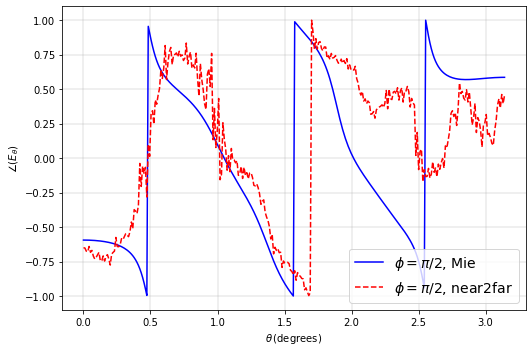

<Figure size 540x360 with 1 Axes>

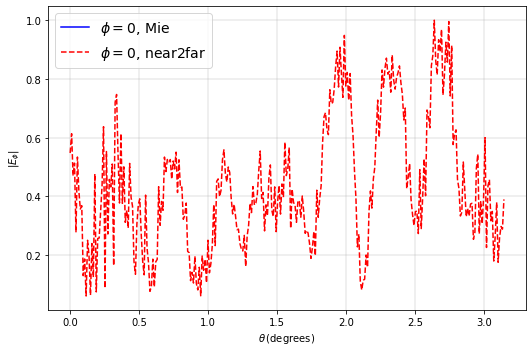

<Figure size 540x360 with 1 Axes>

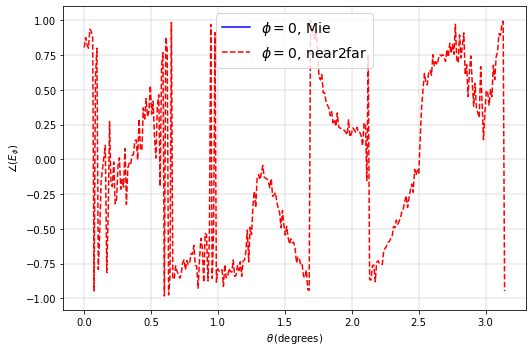

<Figure size 540x360 with 1 Axes>

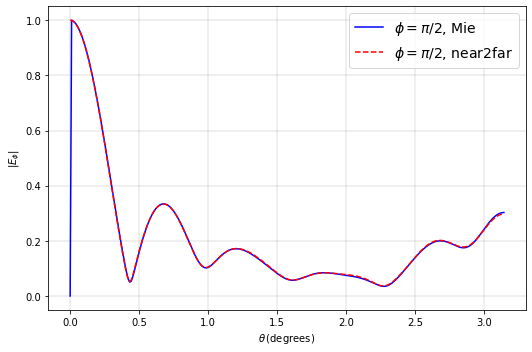

<Figure size 540x360 with 1 Axes>

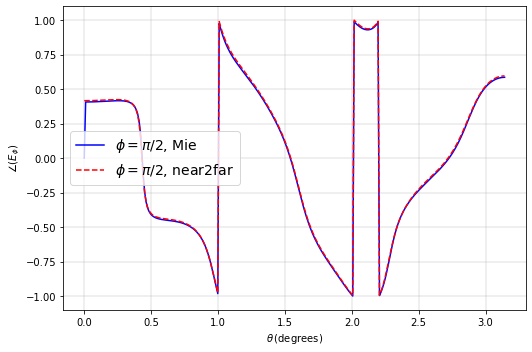

In [20]:
def scale_fn(val):
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

def plot_fn(val):
    return np.abs(val)

def plot_fn2(val):
    val = val / np.max(np.abs(val))
    return val

fileid = '2lambda_epsr4'


# ====== RCS ======

RCS_phi0 = scale_fn(np.squeeze(RCS[:,0]))
RCS_phi90 = scale_fn(np.squeeze(RCS[:,1]))

mie_filename_phi0 = "./data/mie_bRCS_phi0_" + fileid + ".txt"
mie_filename_phi90 = "./data/mie_bRCS_phi90_" + fileid + ".txt"

mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
mie_phi0 = scale_fn(np.squeeze(mie_data_phi0[:,[1]]))

mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
mie_phi90 = scale_fn(np.squeeze(mie_data_phi90[:,[1]]))

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi0, mie_phi0, '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, RCS_phi0, '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi90, mie_phi90, '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, RCS_phi90, '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()


# ====== E ======

Eth_phi0 = ((np.squeeze(E[1,:,0])))
Eth_phi90 = ((np.squeeze(E[1,:,1])))

Eph_phi0 = ((np.squeeze(E[2,:,0])))
Eph_phi90 = ((np.squeeze(E[2,:,1])))

mie_E_filename_phi0 = "./data/mie_E_phi0_" + fileid + ".txt"
mie_E_filename_phi90 = "./data/mie_E_phi90_" + fileid + ".txt"

mie_E_data_phi0 = np.loadtxt(mie_E_filename_phi0, delimiter=' ', skiprows=2)
mie_E_theta_phi0 = np.squeeze(mie_E_data_phi0[:,[0]])
mie_Eth_phi0 = (np.squeeze(mie_E_data_phi0[:,[3]] + 1j*mie_E_data_phi0[:,[4]]))
mie_Eph_phi0 = (np.squeeze(mie_E_data_phi0[:,[5]] + 1j*mie_E_data_phi0[:,[6]]))

mie_E_data_phi90 = np.loadtxt(mie_E_filename_phi90, delimiter=' ', skiprows=2)
mie_E_theta_phi90 = np.squeeze(mie_E_data_phi90[:,[0]])
mie_Eth_phi90 = (np.squeeze(mie_E_data_phi90[:,[3]] + 1j*mie_E_data_phi90[:,[4]]))
mie_Eph_phi90 = (np.squeeze(mie_E_data_phi90[:,[5]] + 1j*mie_E_data_phi90[:,[6]]))

# ------ E_theta, phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eth_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eth_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.angle(mie_Eth_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eth_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\theta)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_theta, phi = 90 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eth_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eth_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\theta|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.angle(mie_Eth_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eth_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\theta)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_phi, phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.abs(mie_Eph_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eph_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi0, plot_fn2(np.angle(mie_Eph_phi0)), '-b', label="$\\phi = 0$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eph_phi0)), '--r', label="$\\phi = 0$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\phi)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ E_phi, phi = 90 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.abs(mie_Eph_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.abs(Eph_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$|E_\\phi|$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_E_theta_phi90, plot_fn2(np.angle(mie_Eph_phi90)), '-b', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, plot_fn2(np.angle(Eph_phi90)), '--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "$\\angle(E_\\phi)$",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

plt.show()